In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw()

In [ ]:
from qiskit.circuit import ParameterVector
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw()

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)
qc_zz.decompose().draw()

In [ ]:
from qiskit.circuit.library import TwoLocal
qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw()

In [ ]:
qc_13 = TwoLocal(3, rotation_blocks='ry',
                 entanglement_blocks='crz', entanglement='sca',
                 reps=3, skip_final_rotation_layer=True,
                 insert_barriers=True)

qc_13.decompose().draw()

In [ ]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw()

# Data Loading

### Basis Encoding

In [ ]:
import math
from qiskit import QuantumCircuit

desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw()

### Amplitude Encoding

In [ ]:
desired_state = [
    1 / math.sqrt(15.25) * 1.5,
    0,
    1 / math.sqrt(15.25) * -2,
    1 / math.sqrt(15.25) * 3]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0,1])

qc.decompose().decompose().decompose().decompose().decompose().draw()

### Angle encoding

In [ ]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2*math.pi/4, 1)
qc.ry(2*math.pi/2, 2)
qc.draw()

### Arbitrary encoding

In [ ]:
from qiskit.circuit.library import EfficientSU2
circuit = EfficientSU2(num_qubits=3, reps=1, insert_barriers=True)
circuit.decompose().draw()

In [ ]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
encode = circuit.bind_parameters(x)
encode.decompose().draw()

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
circuit = ZZFeatureMap(3, reps=1, insert_barriers=True)
circuit.decompose().draw()

In [ ]:
x = [0.1, 0.2, 0.3]
encode = circuit.bind_parameters(x)
encode.decompose().draw()

## Training parameterized quantum circuits

In [1]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

In [2]:
from qiskit.opflow import Z, I
hamiltonian = Z ^ Z

In [3]:
from qiskit.opflow import StateFn, PauliExpectation
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

#### Finite difference gradients

In [5]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
INDEX = 2

In [6]:

EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

0.1861572265625002


In [7]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.16723632812500022

#### Analytic gradients

In [8]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.16015624999999994


In [9]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
sampler.convert(grad, value_dict).eval().real

0.1601562499999999

#### Optimize expectation value

In [10]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

In [11]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

In [12]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)

In [ ]:
result = gd.minimize(
    fun=evaluate_expectation,  # function to minimize
    x0=initial_point,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

#### Natural gradients

In [14]:
from qiskit.opflow import NaturalGradient

In [15]:
natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(
                                                    natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(natural_gradient, params=value_dict).eval()
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587277 -0.86457077 -0.9808614  -0.33820196]


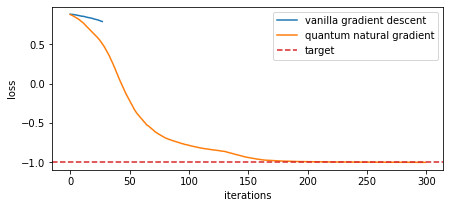

In [18]:
qng_log = OptimizerLog()
qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_log.update)

result = qng.minimize(evaluate_expectation,
                      initial_point,
                      evaluate_natural_gradient)

import matplotlib.pyplot as plt
# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

#### Simultaneous Perturbation Stochastic Approximation

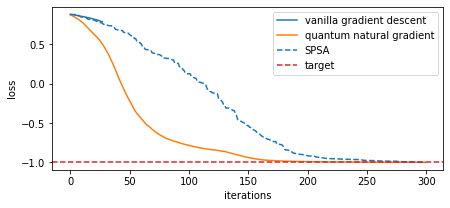

In [20]:
from qiskit.algorithms.optimizers import SPSA
spsa_log = OptimizerLog()
spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_log.update)

result = spsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

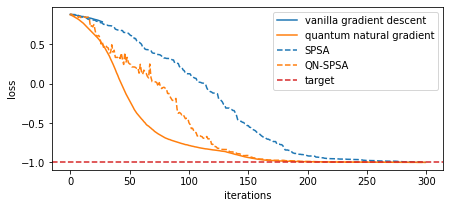

In [21]:
from qiskit.algorithms.optimizers import QNSPSA
qnspsa_log = OptimizerLog()
fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_log.update)

result = qnspsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

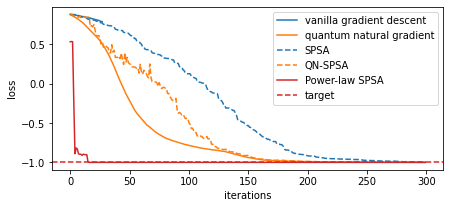

In [22]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_log.update)

result = autospsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', label='Power-law SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

In [23]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.

    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits

    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation,
                              params=ansatz.parameters[index])

    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())

    return grads

In [33]:
from qiskit.opflow import I

def sample_natural_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.

    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits

    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
                          
    natural_gradient = (NaturalGradient(regularization='ridge')
                        .convert(expectation))
    # natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)
    sampler = CircuitSampler(quantum_instance, caching="all")

    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        print("Yo")
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(natural_gradient, params=value_dict).eval())

    return grads

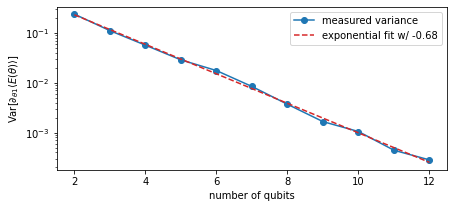

In [24]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

In [34]:
num_qubits = list(range(2, 4))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_natural_gradients(n, r) for n, r in zip(num_qubits, reps)]

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo
Yo


C:\Users\z004c7cw\Anaconda3\envs\qiskit\lib\site-packages\numpy\core\_methods.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


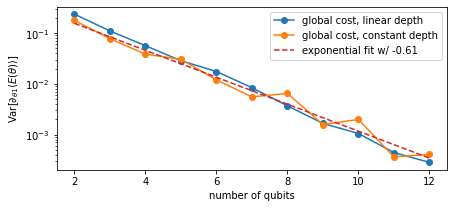

In [25]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

In [ ]:
NUM_QUBITS = 6
OPERATOR = Z ^ Z ^ (I ^ (NUM_QUBITS - 4))

def minimize(circuit, optimizer):
    """
    Args:
        circuit (QuantumCircuit): (Partially bound) ansatz circuit to train
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        OptimizerResult: Result of minimization
    """
    initial_point = np.random.random(circuit.num_parameters)

    exp = StateFn(OPERATOR, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)

    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")

    def loss(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(exp, values_dict).eval())

    def gradient(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.minimize(loss, initial_point, gradient)

def layerwise_training(ansatz, max_num_layers, optimizer):
    """
    Args:
        ansatz (QuantumCircuit): Single circuit layer to train & repeat
        max_num_layers (int): Maximum number of layers
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        float: Lowest value acheived
        list[float]: Best parameters found
    """
    optimal_parameters = []
    for reps in range(max_num_layers):
        ansatz.reps = reps

        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.bind_parameters(values_dict)

        result = minimize(partially_bound, optimizer)
        optimal_parameters += list(result.x)
        print('Layer:', reps, ' Best Value:', result.fun)

    return result.fun, optimal_parameters

ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

np.random.seed(12)  # for reproducibility
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)